# Final project

**Freida's answers**

*What was your biggest challenge in this project? (regarding writing code and not only)*

I think the hardest part was navigating the new file format and the geoparse package for reading in the file. Once the file was read in as a pandas dataframe, everything was much easier. It was also difficult to split work in some ways, because how interdependent all of the pieces of code end up being. 

*What did you learn while working on this project? (regarding writing code and not only)*

I learned a lot about the scikit package, which seems really useful; especially I will say learning how many different options there are to preprocess data and to assess how well a clustering method or machine learning method is working. I also learned how to coordinate a project better with github, which was useful and different from just pulling from the class repository. 

*If you had more time on the project what other question(s) would you like to answer? (at least one question is required)*

One thing I would want to do on this project if I had more time is to generalize the number of disease states/clusters that the code takes in and outputs. I'd also like to implement better exception handling. From a methods perspective, I think it would be interesting to try other methods of clustering the data and see what would be different. I'd also like to ask what features of the expression data were especially useful in separating out the two cancer clusters, and what about the misclassified samples is leading them to be misclassified. 


**Matt's answers**

*What was your biggest challenge in this project? (regarding writing code and not only)*

The hardest part for me was learning to use a new toolkit in the form of sklearn.  The documentation was good, but since Pandas was my weakest portion of the course, it was hard to properly understand and run functions from the package.  Additionally, I personally struggled with having the foresight to see what the order in which things needed to be done would be.  Which made it difficult to assign responsibilities early on and get the project underway.

*What did you learn while working on this project? (regarding writing code and not only)*

This project helped me refine my knowledge priamrily in two areas.  The first helped me shore up my knowledge with dataframes as I was able to continue to work with them myself, as well as see what my code my teammates wrote to deal with the challenges of this project.  The second was that this helped me use matplotlib.pyplot more which helped me think about how data is plotted after being generated, and the amount of complexities that are possible using this package.

*If you had more time on the project what other question(s) would you like to answer? (at least one question is required)*

If I had more time with this project, I would like to answer "which clustering algorithm is best able to correctly cluster our data?".  The scikitlearn package contains other clustering methods such as affinity propogation and agglomerative clustering.  It would be interesting to be able to comparere the differences between the output of these algorithms as even if they have the same approximate "average" accuracy, they may differ in other statistics such as F1 score, or precision. 


##### **Mashiat's answers**

*What was your biggest challenge in this project? (regarding writing code and not only)*

There were a number of challenges that I faced among which the most difficult challenge  for me was to organise my code into functions and avoid hard coding. However, my group mates did an excellent job in organising the code into functions which allowed me to learn from them. 

*What did you learn while working on this project? (regarding writing code and not only)*

I was able to learn how to use sklearn to do clustering. I am familiar with clustering algorithms but I have not applied them on python before. Getting familiar with sklearn helped me to understand how to do clustering on high dimensional data on python. I also learned how to organise my code into functions and document them so that they are easy to read. 

*If you had more time on the project what other question(s) would you like to answer? (at least one question is required)*

I would like to answer, how to project the results from clustering algorithms on two dimensions with methods such as tSNE (T-distributed stochastic neighbor embedding) and UMAP(Uniform Manifold approximation and projection).


**Importing packages and defining functions**

In [1]:
import GEOparse
import pandas as pd
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import seaborn as sns
from sklearn import preprocessing

In [2]:
#load the data
def load_data(soft_file):
    """
    This function uses geoparse to read the dataset located in a soft file into a dataframe named pheno_data, and a data table named gse_make_table.
    inputs  -soft_file, the name of the soft file that will be parsed through
    outputs -pheno_data contains the sample title and the type of cancer that the sample belongs to.
            -gse_make_table contains the expression information for a series of loci across the genome.
    
    """
    gse = GEOparse.get_GEO(geo=soft_file, destdir="./")
    gse_make_table = gse.pivot_samples('VALUE')
    gse_pheno_data=gse.phenotype_data[["title", "characteristics_ch1.0.disease state"]]
    gse_pheno_data=gse_pheno_data.rename(columns={'characteristics_ch1.0.disease state':"TrueDiseaseLabel"})
    gse_pheno_data['TrueDiseaseLabel'].unique()
    return gse_pheno_data, gse_make_table


In [3]:
#normalize data function
def NormalizeData_PCA(expression_data_1, normOption, pca_components):
    """
    This function normalizes expression data. First, it uses preprocessing.normalize and then it scales the data
    Finally, it runs a PCA
    inputs - expression data, where rows are markers and columns are samples
            - normOption: how do you want to normalize data
            -pca_components - how many PCs do you want to retain
    outputs - PCs reduced data for use in downstream analysis 
    """
    normalized_data = preprocessing.normalize(expression_data_1, norm=normOption)
    scale_data = scale(normalized_data)
    scale_data = scale_data.transpose()
    reduced_data = PCA(n_components=pca_components).fit_transform(scale_data)
    return reduced_data

In [4]:
#add kmeans labels to dataframe function
def AddClusterLabels(phenotype_data, disease_states, disease_state_1, disease_state_2):
    """
    This function adds Cluster labels to the dataframe based on k means clustering 
    Since KMeans outputs integers instead of labels, this function uses a cross tab to see which 
    disease state should be assigned to which cluster label, based on which cluster label has more assignments from a disease state
    If exactly equal assignments in each disease state, it prints a warning that clustering split evenly
    Note: this function is written for only two disease states, but could be extended to more
    inputs: - phenotype_data (pandas dataframe with the true phenotypes, labels (0/1) from kmeans and sample names)
            - disease_states (name of column in phenotype_data containing the true labels)
            - disease_state_1 (name of 1st disease state)
            - disease_state_2 (name of 2nd disease state)
    outputs: - new phenotype data frame, with an additional column "NamedClusters"
    """
    xtab = pd.crosstab(phenotype_data[disease_states], phenotype_data['ClustersfromPCA'])
    if xtab.loc[disease_state_1, 0]>xtab.loc[disease_state_1, 1]:
        phenotype_data['NamedClusters'] =  np.where(phenotype_data['ClustersfromPCA']==0, disease_state_1, disease_state_2)
    elif xtab.loc[disease_state_1, 0]<xtab.loc[disease_state_1, 1]:
         phenotype_data['NamedClusters'] =  np.where(phenotype_data['ClustersfromPCA']==1, disease_state_1, disease_state_2)
    elif xtab.loc[disease_state_1, 0]==xtab.loc[disease_state_1, 1]:
        print("Clustering split evenly! Maybe try different parameters in Kmeans?")
    return phenotype_data
    

In [5]:
def TrainTestSplit(expression_data, phenotype_data, disease_states, disease_state_1, disease_state_2, split):
    """
    This function splits expression and phenotype data sets into training and testing sets by randomly 
    sampling a set number of each disease state 
    Note: this function is written for only two disease states, but could be extended to more
    inputs -  expression data, where rows are markers and columns are samples
            - phenotype_data(pandas dataframe with the true phenotypes and sample names)
            - disease_states (name of column in phenotype_data containing the true labels)
            - disease_state_1 (name of 1st disease state)
            - disease_state_2 (name of 2nd disease state)
            - split - a value between 0 & 1, the proportion of each disease state you want in the training table. 
                by default 1-split will end up in the testing set
    outputs - train_data - phenotype data (training)
            - test_data - phenotype data (testing)
            - train_expression - expression data (training)
            -test_expression - expression data (testing)
    """
    #Get the split percentage from each disease state
    d1_split = phenotype_data[phenotype_data[disease_states]==disease_state_1]
    d2_split = phenotype_data[phenotype_data[disease_states]==disease_state_2]
    d1_n = int(split*d1_split.shape[0])
    d2_n=int(split* d2_split.shape[0])
    #get phenotype test and train data
    train_data = d1_split.sample(n=d1_n).append(d2_split.sample(n=d2_n))
    test_data = phenotype_data[~phenotype_data['title'].isin(train_data["title"])]
    #get expression test and train data
    train_expression = expression_data[expression_data.columns.intersection(train_data.index)]
    test_expression = expression_data[expression_data.columns.intersection(test_data.index)]
    return train_data, test_data, train_expression, test_expression
    

In [6]:
def RunKmeans(expression_data, phenotype_data, disease_states, normOption, pca_components, trainAndtest, split): 
    """
    RunKmeans if trainAndtest == No, then RunKmeans will run a kmeans clustering algorithim 
    on PCA-reduced and normalized expression data using the number of unique disease state labels as the
    number of clusters. If trainAndtest == Yes, the function will first split the expression data into training
    and testing sets, then train kmeans using training set and test on testing set
    input: - expression_data, where rows are markers and columns are samples
            - phenotype_data(pandas dataframe with the true phenotypes and sample names)
            - disease_states (name of column in phenotype_data containing the true labels)
            -normOption - how you want the data normalized, i.e. l2
            -pca components - the number of PCs you want
            -trainAndtest - yes or no for training and testing or not
            - split - a value between 0 & 1, the proportion of each disease state you want in the training table. 
                by default 1-split will end up in the testing set
           
    output: if trainAndtest = no, a new phenotype dataset that contains both the original true labels and the labes from clustering (all samples)
    if train and test = yes, a new test dataset that  contains both the original true labels and the labes from clustering (only samples in test)
    """
    #First, set parameters
    n_features, n_samples = expression_data.shape
    n_cluster_var = phenotype_data[disease_states].value_counts().shape[0]
    disease_state_1 = phenotype_data[disease_states].unique()[0]
    disease_state_2 = phenotype_data[disease_states].unique()[1]
    #define kmeans
    kmeans = KMeans(init='k-means++', n_clusters=n_cluster_var, random_state=0, n_init=10)
    if trainAndtest=="No":
        #Preprocessing data & run PCA
        reduced_data = NormalizeData_PCA(expression_data, normOption, pca_components)
        #add clusters to dataset
        phenotype_data_new = phenotype_data.copy()
        phenotype_data_new['ClustersfromPCA'] = kmeans.fit(reduced_data).labels_.tolist()
        #determine cluster labels
        phenotype_data_new = AddClusterLabels(phenotype_data_new, disease_states, disease_state_1, disease_state_2) 
        return phenotype_data_new
    if trainAndtest == "Yes":
        #split data
        train_data, test_data, train_expression, test_expression = TrainTestSplit(expression_data, phenotype_data, disease_states, disease_state_1, disease_state_2, split)
        #Preprocessing train & test data & run PCA
        train_norm = NormalizeData_PCA(train_expression, normOption, pca_components)
        test_norm = NormalizeData_PCA(test_expression, normOption, pca_components)
        #train model using train data
        kmeans.fit(train_norm)
        #predict using predict 
        test_data_new = test_data.copy()
        test_data_new["ClustersfromPCA"] = kmeans.predict(test_norm).tolist()
        #determine cluster labels
        test_data_new = AddClusterLabels(test_data_new, disease_states, disease_state_1, disease_state_2)
        return test_data_new

In [7]:
def Compute_Metrics(DataframeWithLabels, TrueLabels, PredictedLabels, abbrev1, abbrev2):
    """
    Compute metrics computes the accuracy for the clustering as well as the precision, recall and F1 stat when
    considering either of the two labels as a 'positive'
    input - DataframeWithLabels - Dataframe with both labels that are true and labels from predicted clusters
            - TrueLabels - column name of true labels
            - PredictedLabels - column name of predicted labels
    output: Metrics datastructure, a dictionary containing accuracy, and then
    recall, precision and F1 for when one of each disease states is considered a positive
    """
    LabelPositive_1 = DataframeWithLabels[TrueLabels].unique()[0]
    LabelPositive_2 = DataframeWithLabels[TrueLabels].unique()[1]
    Accuracy = metrics.accuracy_score(DataframeWithLabels[TrueLabels], DataframeWithLabels[PredictedLabels])*100
    Precision_1=metrics.precision_score(DataframeWithLabels[TrueLabels], DataframeWithLabels[PredictedLabels], pos_label=LabelPositive_1)*100
    Recall_1 = metrics.recall_score(DataframeWithLabels[TrueLabels], DataframeWithLabels[PredictedLabels], pos_label=LabelPositive_1)*100
    F1_1 = metrics.f1_score(DataframeWithLabels[TrueLabels], DataframeWithLabels[PredictedLabels], pos_label=LabelPositive_1)*100
    Precision_2 = metrics.precision_score(DataframeWithLabels[TrueLabels], DataframeWithLabels[PredictedLabels], pos_label=LabelPositive_2)*100
    Recall_2 = metrics.recall_score(DataframeWithLabels[TrueLabels], DataframeWithLabels[PredictedLabels], pos_label=LabelPositive_2)*100
    F1_2 = metrics.f1_score(DataframeWithLabels[TrueLabels], DataframeWithLabels[PredictedLabels], pos_label=LabelPositive_2)*100
    print(f"Accuracy is {round(Accuracy, 2)}. When considering {LabelPositive_1} as a positive, precision is {round(Precision_1, 2)}, recall is {round(Recall_1, 2)} and F1 score is {round(F1_1, 2)}. When considering {LabelPositive_2} as a positive, precision is {round(Precision_2, 2)}, recall is {round(Recall_2, 2)} and F1 score is {round(F1_2, 2)}")
    Metrics_datastructure = {"Accuracy":Accuracy, abbrev1+"_Precision": Precision_1, abbrev1+"_Recall":Recall_1, abbrev1+"_F1":F1_1, abbrev2+"_Precision": Precision_2, abbrev2+"_Recall":Recall_2, abbrev2+"_F1":F1_2}
    return Metrics_datastructure

**Load in Data**

In [8]:
pheno_data, gse_table = load_data("GSE10245")

01-Dec-2019 23:42:25 DEBUG utils - Directory ./ already exists. Skipping.
01-Dec-2019 23:42:25 INFO GEOparse - File already exist: using local version.
01-Dec-2019 23:42:25 INFO GEOparse - Parsing ./GSE10245_family.soft.gz: 
01-Dec-2019 23:42:25 DEBUG GEOparse - DATABASE: GeoMiame
01-Dec-2019 23:42:25 DEBUG GEOparse - SERIES: GSE10245
01-Dec-2019 23:42:25 DEBUG GEOparse - PLATFORM: GPL570
/Users/mashiatrabbani/anaconda3/lib/python3.7/site-packages/GEOparse/GEOparse.py:88: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return parse_GSE(filepath)
01-Dec-2019 23:42:29 DEBUG GEOparse - SAMPLE: GSM258551
01-Dec-2019 23:42:29 DEBUG GEOparse - SAMPLE: GSM258552
01-Dec-2019 23:42:29 DEBUG GEOparse - SAMPLE: GSM258553
01-Dec-2019 23:42:29 DEBUG GEOparse - SAMPLE: GSM258554
01-Dec-2019 23:42:30 DEBUG GEOparse - SAMPLE: GSM258555
01-Dec-2019 23:42:30 DEBUG GEOparse - SAMPLE: GSM258556
01-Dec-2019 23:42:30 DEBUG GEOparse - SAMPLE: GSM258557
01

**Main project**

In [9]:
NewDF=RunKmeans(expression_data=gse_table, phenotype_data=pheno_data, disease_states='TrueDiseaseLabel', normOption='l2', pca_components=2, trainAndtest='No', split=0)
non_ec_stats = Compute_Metrics(NewDF, TrueLabels='TrueDiseaseLabel', PredictedLabels='NamedClusters', abbrev1='AC', abbrev2="SCC")

Accuracy is 93.1. When considering adenocarcinoma as a positive, precision is 95.0, recall is 95.0 and F1 score is 95.0. When considering squamous cell carcinoma as a positive, precision is 88.89, recall is 88.89 and F1 score is 88.89


In [10]:
NewDF # All samples

,title,TrueDiseaseLabel,ClustersfromPCA,NamedClusters
GSM258551,NSCLC_AC_10,adenocarcinoma,0,adenocarcinoma
GSM258552,NSCLC_AC_16,adenocarcinoma,0,adenocarcinoma
GSM258553,NSCLC_SCC_22,squamous cell carcinoma,1,squamous cell carcinoma
GSM258554,NSCLC_AC_24,adenocarcinoma,0,adenocarcinoma
GSM258555,NSCLC_SCC_25,squamous cell carcinoma,1,squamous cell carcinoma
GSM258556,NSCLC_SCC_30,squamous cell carcinoma,0,adenocarcinoma
GSM258557,NSCLC_SCC_37,squamous cell carcinoma,1,squamous cell carcinoma
GSM258558,NSCLC_AC_40,adenocarcinoma,0,adenocarcinoma
GSM258559,NSCLC_AC_49,adenocarcinoma,0,adenocarcinoma
GSM258560,NSCLC_AC_51,adenocarcinoma,0,adenocarcinoma


**Extra credit**

In [10]:
NewDFTest = RunKmeans(expression_data=gse_table, phenotype_data=pheno_data, disease_states='TrueDiseaseLabel', normOption='l2', pca_components=2, trainAndtest='Yes', split=0.5)
ec_stats = Compute_Metrics(NewDFTest, TrueLabels='TrueDiseaseLabel', PredictedLabels='NamedClusters', abbrev1='AC', abbrev2="SCC")

Accuracy is 75.86. When considering adenocarcinoma as a positive, precision is 100.0, recall is 65.0 and F1 score is 78.79. When considering squamous cell carcinoma as a positive, precision is 56.25, recall is 100.0 and F1 score is 72.0


In [11]:
NewDFTest #Only samples in test dataset

,title,TrueDiseaseLabel,ClustersfromPCA,NamedClusters
GSM258552,NSCLC_AC_16,adenocarcinoma,0,squamous cell carcinoma
GSM258555,NSCLC_SCC_25,squamous cell carcinoma,0,squamous cell carcinoma
GSM258559,NSCLC_AC_49,adenocarcinoma,1,adenocarcinoma
GSM258560,NSCLC_AC_51,adenocarcinoma,1,adenocarcinoma
GSM258561,NSCLC_AC_53,adenocarcinoma,1,adenocarcinoma
GSM258565,NSCLC_SCC_75,squamous cell carcinoma,0,squamous cell carcinoma
GSM258566,NSCLC_SCC_77,squamous cell carcinoma,0,squamous cell carcinoma
GSM258570,NSCLC_SCC_95,squamous cell carcinoma,0,squamous cell carcinoma
GSM258571,NSCLC_AC_97,adenocarcinoma,1,adenocarcinoma
GSM258574,NSCLC_AC_137,adenocarcinoma,0,squamous cell carcinoma


**A Nice Plot**

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

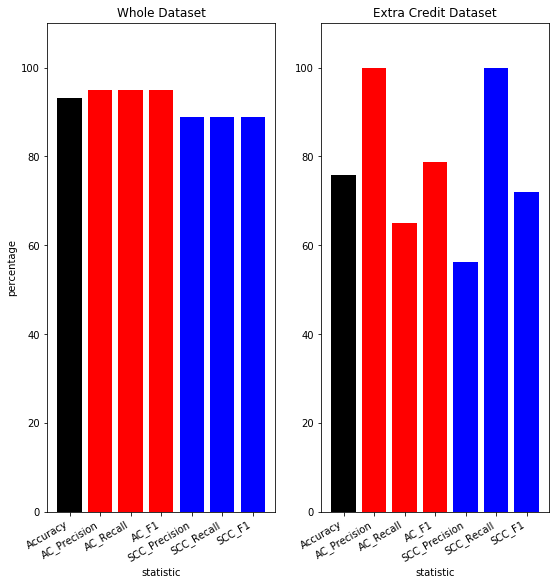

In [12]:
plt.figure(figsize=(9,9))

plt.subplot(121)
#plot on the left contains the whole kmeans clustering data for the whole data set.
plt.title('Whole Dataset')
#used https://python-graph-gallery.com/3-control-color-of-barplots/ to generate colors of bar graph
plt.bar(non_ec_stats.keys(), non_ec_stats.values(), color=['black', 'red','red','red', 'blue', 'blue', 'blue'])
plt.ylabel("percentage")
plt.xlabel("statistic")
plt.ylim(0, 110)     
#used https://www.pythoncharts.com/2019/05/17/rotating-axis-labels/ to manipulate x axis labels
plt.xticks(rotation=30, ha='right')

#plot on the right contains the kmeans clustering test half of the dataset dataset after it has been trained with half the dataset.
plt.subplot(122)
plt.title('Extra Credit Dataset')
plt.bar(ec_stats.keys(), ec_stats.values(), color=['black', 'red','red','red', 'blue', 'blue', 'blue'])
plt.xlabel("statistic")
plt.ylim(0, 110)
plt.xticks(rotation=30, ha='right')
   

References: 

Scikit-learn.org. (2019). A demo of K-Means clustering on the handwritten digits data — scikit-learn 0.21.3 documentation. [online] Available at: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py [Accessed 2 Dec. 2019].

Scikit-learn.org. (2019). 5.3. Preprocessing data — scikit-learn 0.21.3 documentation. [online] Available at: https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization [Accessed 2 Dec. 2019].